In [ ]:
# This notebook we will use for preprocessing data/cleaning data/text parsing and Exploratory Data Analysis

In [ ]:
# Import relevant libraries
import pandas as pd
import numpy as np
import re
import nltk
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [ ]:
# Get Data, clean and prepare for EDA, mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
%cd /content/gdrive/MyDrive/STOR565_Final/datasets

Mounted at /content/gdrive
/content/gdrive/MyDrive/STOR565_Final/datasets


In [ ]:
# loading data, previews
raw_text = pd.read_csv("raw_data_TDAVIDSON.csv")
#raw_text = pd.read_csv("/content/sample_data/raw_data_TDAVIDSON.csv")

raw_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                24783 non-null  int64 
 1   count                     24783 non-null  int64 
 2   hate_speech_count         24783 non-null  int64 
 3   offensive_language_count  24783 non-null  int64 
 4   neither_count             24783 non-null  int64 
 5   class                     24783 non-null  int64 
 6   tweet                     24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [ ]:
# prompt: list all the datatypes of the variables in raw_text
raw_text
raw_text.dtypes


Unnamed: 0                   int64
count                        int64
hate_speech_count            int64
offensive_language_count     int64
neither_count                int64
class                        int64
tweet                       object
dtype: object

In [ ]:
# Define a minimal list of English stopwords
#stopwords = {'the', 'is', 'at', 'which', 'and', 'in', 'on', 'for', 'with', 'without', 'as', 'a', 'an'}
#common_contractions = ["n't", "ain't", "'s", "'m", "can't", "y'all", "i'm", "i've", "you're", "we're"]

nltk.download('stopwords')
# Function to clean tweets
def clean_tweet(tweet):
    tweet = tweet.lower() #Lowercase
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)     # Remove URLs
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'[^\w\s\']', '', tweet)  # Remove special characters except apostrophes
    tweet = re.sub(r'\s+', ' ', tweet).strip()     # Remove extra whitespace
    tweet = re.sub(r'rt', ' ', tweet).strip() # Remove "rt"
    tweet = re.sub(r'@[^\s]+', '', tweet)  # Remove user handles
    tweet_tokens = tweet.split()  # Split tweet into words
    tweet = ' '.join([word for word in tweet_tokens if word not in stopwords.words('english')])
    return tweet

#For Data Visualization purposes
'''def filter(tweet):
    #tweet = tweet.replace('nigga', 'n*gga')
    #tweet = tweet.replace('nigger', 'n*gger')
    #tweet = tweet.replace('faggot', 'f*ggot')
    #tweet = tweet.replace('fuck', 'f*ck')'''

# Apply cleaning function to tweets
if 'tweet' in raw_text.columns:
    raw_text['clean_tweet'] = raw_text['tweet'].apply(clean_tweet)
    raw_text = raw_text.rename(columns={'tweet': 'og_tweet'})

raw_text['tweet_length'] = raw_text['clean_tweet'].apply(len)

# Display the first few rows to verify the cleaning
print(f'Number of entries after cleaning: {raw_text.shape[0]}')

raw_text.head(25)
raw_text.dtypes

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Number of entries after cleaning: 24783


Unnamed: 0                   int64
count                        int64
hate_speech_count            int64
offensive_language_count     int64
neither_count                int64
class                        int64
og_tweet                    object
clean_tweet                 object
tweet_length                 int64
dtype: object

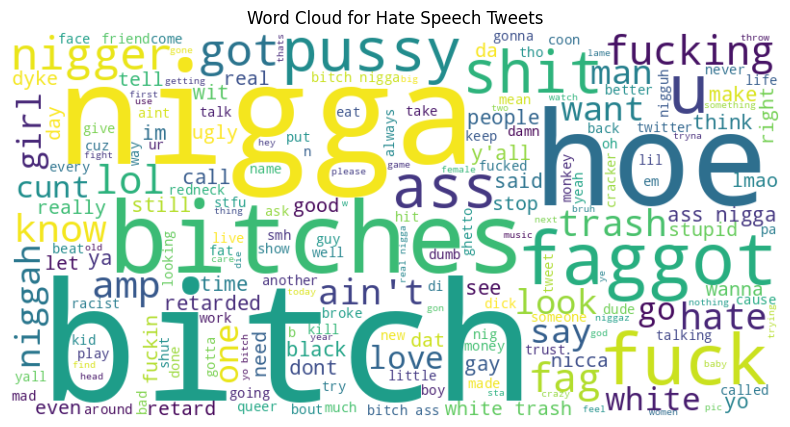

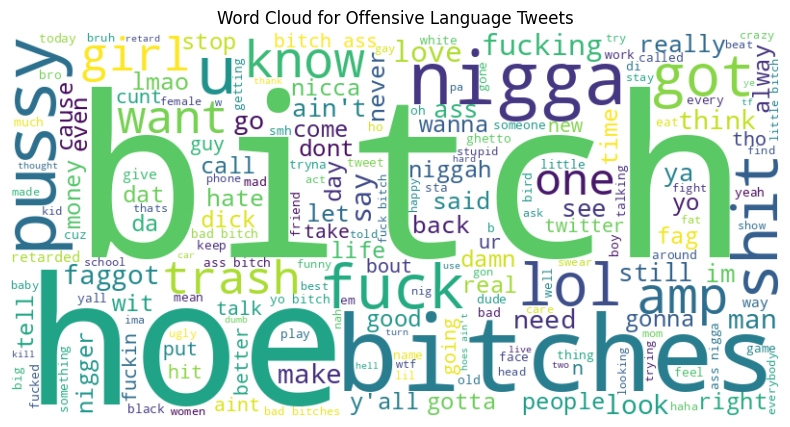

In [ ]:
# Filter tweets with hate speech and offensive language counts
hate_speech_tweets = raw_text[raw_text['hate_speech_count'] > 0]['clean_tweet'].str.cat(sep=' ')
offensive_language_tweets = raw_text[raw_text['offensive_language_count'] > 0]['clean_tweet'].str.cat(sep=' ')

# Generate a word cloud for hate speech tweets
wordcloud_hs = WordCloud(width = 800, height = 400, background_color ='white').generate(hate_speech_tweets)

# Generate a word cloud for offensive language tweets
wordcloud_ol = WordCloud(width = 800, height = 400, background_color ='white').generate(offensive_language_tweets)

# Plot the word cloud for hate speech
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_hs, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hate Speech Tweets')
plt.show()

# Plot the word cloud for offensive language
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_ol, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Offensive Language Tweets')
plt.show()


In [ ]:
#EDA Options to explore
'''
1. Text Length Analysis
Distribution of Text Length: Analyze the distribution of text lengths to understand the variability in your dataset. You can plot histograms or boxplots of the number of words or characters per tweet.
Comparison by Class: Compare the distribution of text lengths across different categories (e.g., hate speech vs. non-hate speech) to see if the text length can be an indicative feature.

2. Word Frequency Analysis
Most Common Words: Identify and visualize the most frequent words in the entire dataset and within each category. This can help in understanding common themes and identifying stopwords.
Word Clouds: Generate word clouds for the entire dataset and for each category to visualize the most prominent words in a more intuitive format.

3. N-grams Analysis
Common N-grams: Explore the most common bi-grams (pairs of words) and tri-grams (triplets of words) in the dataset. N-grams can help capture phrases that have specific meanings beyond individual words.
N-gram Frequency by Class: Analyze the frequency of n-grams within each class to uncover patterns or phrases characteristic of hate speech.

4. Sentiment Analysis
Overall Sentiment: Use pre-built sentiment analysis tools to get a sense of the overall sentiment in your dataset. Compare the sentiment scores across different classes to see if hate speech tends to have a more negative sentiment.

5. Part-of-Speech Tagging
POS Distribution: Analyze the distribution of parts of speech (nouns, verbs, adjectives, etc.) in your texts. This can help identify if certain parts of speech are more prevalent in hate speech.

6. Topic Modeling
Identify Themes: Use techniques like Latent Dirichlet Allocation (LDA) to identify common themes or topics within your dataset. This can help in understanding the different subjects around which hate speech might revolve.

7. Correlation Analysis
Feature Correlation: Explore correlations between different textual features (e.g., text length, sentiment score) and the target variable (e.g., class of hate speech). This can help identify the most relevant features for model training.

Data Quality Checks
Missing Values: Identify and handle missing values in your dataset.
Outliers: Detect outliers in numerical features, like text length, that may affect model performance.
'''

'\n1. Text Length Analysis\nDistribution of Text Length: Analyze the distribution of text lengths to understand the variability in your dataset. You can plot histograms or boxplots of the number of words or characters per tweet.\nComparison by Class: Compare the distribution of text lengths across different categories (e.g., hate speech vs. non-hate speech) to see if the text length can be an indicative feature.\n\n2. Word Frequency Analysis\nMost Common Words: Identify and visualize the most frequent words in the entire dataset and within each category. This can help in understanding common themes and identifying stopwords.\nWord Clouds: Generate word clouds for the entire dataset and for each category to visualize the most prominent words in a more intuitive format.\n\n3. N-grams Analysis\nCommon N-grams: Explore the most common bi-grams (pairs of words) and tri-grams (triplets of words) in the dataset. N-grams can help capture phrases that have specific meanings beyond individual wo

###Rujula - trying the EDA options based on cleaned data

####n-grams analysis

In [ ]:
raw_text.head()

,Unnamed: 0,count,hate_speech_count,offensive_language_count,neither_count,class,og_tweet,clean_tweet,tweet_length
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,mayasolovely woman complain cleaning house amp...,68
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,mleew boy dats coldtyga dwn bad cuffin dat hoe...,55
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,urkindofbrand dawg sbabylife ever fuck bitch s...,66
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,c_g_anderson viva_based look like tranny,40
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shenikarobe shit hear might true might faker b...,58


In [ ]:
# calculating the n-grams for sets of 3 words in hate speech

hate_speech_words = hate_speech_tweets.split()
ngram_3 = list(ngrams(hate_speech_words, 3))
counts3 = Counter(ngram_3)

In [ ]:
# plotting the top 15 combos
top_ngrams = counts3.most_common(15)

ngrams, counts = zip(*top_ngrams)
ngrams_str = [' '.join(ngram) for ngram in ngrams]

plt.bar(ngrams_str, counts, color='chocolate')
plt.xlabel(f'{3}-grams')
plt.ylabel('Occurrences')
plt.title(f'Top {15} {3}-grams Analysis - Hate Speech')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# calculating the n-grams for sets of 3 words in offensive language
from nltk.util import ngrams
offensive_language_words = offensive_language_tweets.split()
ngram_3_offensive = list(ngrams(offensive_language_words, 3))
counts3_offensive = Counter(ngram_3_offensive)

# plotting the top 15 combos
top_ngrams_o = counts3_offensive.most_common(15)

ngrams_o, counts_o = zip(*top_ngrams_o)
ngrams_str_o = [' '.join(ngram) for ngram in ngrams_o]

plt.bar(ngrams_str_o, counts_o, color='maroon')
plt.xlabel(f'{3}-grams')
plt.ylabel('Occurrences')
plt.title(f'Top {15} {3}-grams Analysis - Offensive Language')
plt.xticks(rotation=45, ha='right')
plt.show()

####Text Length Analysis

In [ ]:
# separating the classification and clean text into a new dataframe
new_text = raw_text[['clean_tweet','class']]
new_text

In [ ]:
# examining text length

new_text['length'] = new_text['clean_tweet'].apply(len)
class1_lengths = new_text[new_text['class']==1]['length']
class2_lengths = new_text[new_text['class']==2]['length']
class0_lengths = new_text[new_text['class']==0]['length']

bins = list(range(0,300,25))

class0_lengths.hist(bins=bins, color='chocolate', edgecolor='black', linewidth=2)
plt.title('Text Length - Class 0 (Hate speech)')
plt.xlabel('Length of Tweet')
plt.ylabel('# of Tweets')
plt.xlim(0, 200)  # Set x-limit to 200
plt.xticks(range(0, 201, 25))  # Add spacing between bins
plt.show()

class1_lengths.hist(bins=bins, color='maroon', edgecolor='black', linewidth=2)
plt.title('Text Length - Class 1 (Offensive Language)')
plt.xlabel('Length of Tweet')
plt.ylabel('# of Tweets')
plt.xlim(0, 200)  # Set x-limit to 200
plt.xticks(range(0, 201, 25))  # Add spacing between bins
plt.show()

class2_lengths.hist(bins=bins, color='mediumseagreen', edgecolor='black', linewidth=2)
plt.title('Text Length - Class 2 (Neither)')
plt.xlabel('Length of Tweet')
plt.ylabel('# of Tweets')
plt.xlim(0, 200)  # Set x-limit to 200
plt.xticks(range(0, 201, 25))  # Add spacing between bins
plt.show()


####Sentiment Analysis

In [ ]:
# defining a function for assigning a sentiment score

# Download the VADER sentiment analysis model (run only once)
nltk.download('vader_lexicon')

def get_sentiment_score(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)['compound']
    return sentiment_score

In [ ]:
# applying it to cleaned tweets - this takes a couple minutes

new_text['sentiment_score'] = new_text['clean_tweet'].apply(get_sentiment_score)
new_text

In [ ]:
# plotting the sentiment scores across the classes

class0_sentiments = new_text[new_text['class']==0]['sentiment_score']
class1_sentiments = new_text[new_text['class']==1]['sentiment_score']
class2_sentiments = new_text[new_text['class']==2]['sentiment_score']

class0_sentiments.hist(color='chocolate', edgecolor='black', linewidth=1)
plt.title('Sentiment Score - Class 0 (Hate Speech)')
plt.xlabel('Sentiment Score')
plt.ylabel('# of Tweets')
plt.show()

class1_sentiments.hist(color='maroon', edgecolor='black', linewidth=1)
plt.title('Sentiment Score - Class 1 (Offensive Language)')
plt.xlabel('Sentiment Score')
plt.ylabel('# of Tweets')
plt.show()

class2_sentiments.hist(color='mediumseagreen', edgecolor='black', linewidth=1)
plt.title('Sentiment Score - Class 2 (Neither)')
plt.xlabel('Sentiment Score')
plt.ylabel('# of Tweets')
plt.show()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import tensorflow
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

# Assume 'tweets_series' is your pandas series containing hate speech tweets
tweets_series = raw_text['og_tweet']
# Preprocessing
stop_words = set(stopwords.words('english'))
tweets = [word_tokenize(tweet.lower()) for tweet in tweets_series]
tweets = [[word for word in tweet if word not in stop_words] for tweet in tweets]

# Convert tweets to sequences of word indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Create the model
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

# Add convolutional layers with different kernel sizes
for filter_size in range(1, 4):  # Analyze 1-word, 2-word, and 3-word combinations
    model.add(Conv1D(128, filter_size, activation='relu'))
    model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Use the model to predict hate speech
def predict_hate_speech(tweet):
    tweet_seq = tokenizer.texts_to_sequences([tweet.lower()])
    padded_seq = pad_sequences(tweet_seq, maxlen=max_length, padding='post')
    prediction = model.predict(padded_seq)[0][0]
    return prediction >= 0.5  # Return True if prediction is >= 0.5, indicating hate speech

# Example usage
tweet = "I hate you!"
is_hate_speech = predict_hate_speech(tweet)
print(is_hate_speech)


In [ ]:
tweets = raw_text['tweet']
words = ' '.join(tweets).split()
vocab = set(words)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Encode tweets into numerical indices
encoded_tweets = [[word_to_index[word] for word in tweet.split()] for tweet in tweets]
print("Vocabulary size:", len(vocab))
print("Encoded tweets:", encoded_tweets)

# Neural network parameters
input_size = len(vocab)
hidden_size = 10
output_size = 1
learning_rate = 0.01

# Initialize weights and biases
np.random.seed(0)
W1 = np.random.randn(hidden_size, input_size)
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size)
b2 = np.zeros((output_size, 1))

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Forward propagation
def forward_propagation(inputs):
    # Input layer to hidden layer
    Z1 = np.dot(W1, inputs) + b1
    A1 = sigmoid(Z1)
    # Hidden layer to output layer
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    return A2

# Example usage
input_tweet = "I hate you!"
input_indices = [word_to_index[word] for word in input_tweet.split()]
input_vector = np.zeros((len(vocab), 1))
for index in input_indices:
    input_vector[index] = 1

output = forward_propagation(input_vector)
print("Input tweet:", input_tweet)
print("Output:", output)


Elizabeth:

https://ojs.aaai.org/index.php/ICWSM/article/view/14955

Potential techniques:
- Logistic Regression Model
- Random Forest Classifier
- SVM Classfier
- TF-IDF Scores: https://www.youtube.com/watch?v=upgSG5-0Qmk
  - Stemmin/Lemmitazation: Ways to counterbalance conjugation






In [ ]:
#Create Vectorizer
only_text = raw_text['clean_tweet']
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(only_text)
tfidf = tfidf.toarray()
tfidf.shape
tfidf


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#Bag of Words that can be used with any Vectorizer
word_bag = vectorizer.get_feature_names_out()

In [ ]:
# Attempt at trying to visualize the TF-IDF Values
tfidf_df = pd.DataFrame(tfidf, columns=word_bag)
tfidf_df.head(10)
# subset = df.iloc[:5, :3] In case we cant to view specific rows/columns
# We have 24783 tweets and the column have words that appear somewhere in these tweets. If a zero is present, implies the word is not in that tweet.

,__,___,____,_____,_______,________,__________,_____________,_________________________,________o_____,...,zulu,zvckslvtr,zwaaad,zwengersierra,zwhite,zwithr,zzachbarness,zzzentropy,zzzquil,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Buld a Logistic Regression Model
raw_text['hate_speech_binary'] = (raw_text['hate_speech_count'] > 0).astype(int)
Y = raw_text['hate_speech_binary']
X = tfidf
x_train, x_test, y_train, y_test = train_test_split(X, Y)
model = LogisticRegression().fit(x_train, y_train)
model.predict_proba(x_test)

array([[0.80310267, 0.19689733],
       [0.85234706, 0.14765294],
       [0.4766461 , 0.5233539 ],
       ...,
       [0.91427785, 0.08572215],
       [0.86252427, 0.13747573],
       [0.87904491, 0.12095509]])

In [ ]:
print(model.coef_.shape)
coef = model.coef_.reshape(-1)
key_word = np.argmax(coef)
word_bag[key_word]
idx = np.argsort(coef)[-10:]
word_bag[idx]

(1, 33151)


array(['queer', 'fags', 'niggers', 'white', 'fag', 'faggots', 'niggas',
       'nigga', 'nigger', 'faggot'], dtype=object)

In [ ]:
model.score(x_test, y_test)

0.8284377017430601

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(
    only_text,
    raw_text['hate_speech_binary'],
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=raw_text['hate_speech_binary']
)

# Random Forest Algorithm with TF-IDF Vectorizer
from sklearn.ensemble import RandomForestClassifier

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('Random_Forest',RandomForestClassifier())
])

#2. fit with X_train and y_train
rf_model = clf.fit(x_train_rf, y_train_rf)


#3. get the predictions for X_test and store it in y_pred
y_pred_rf = clf.predict(x_test_rf)





In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_rf, y_pred_rf))
rf_model.score(x_test_rf, y_test_rf)

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3958
           1       0.72      0.29      0.41       999

    accuracy                           0.83      4957
   macro avg       0.78      0.63      0.66      4957
weighted avg       0.82      0.83      0.81      4957



0.8347791002622554

In [ ]:
# Naive Bayes with TF-IDF Vectorizer


In [ ]:
# K-Nearest Neighbor with TF-IDF